In [ ]:
# Movie sentiment analysis
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
%load_ext google.colab.data_table 

!wget https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/preprocess.py
import preprocess
from string import punctuation

In [ ]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  
  return train_df


def printInputOutput(index, train, train_text, train_label):
  print("Original input:", train['sentence'][index])
  print("Preprocessed text:", train_text[index])
  print("\nConverted to vector:", sequences[index])
  print("Sentiment label:", train_label[index])
  print("--------------------------")

  # Check the text to number conversion
  currentIndex = 0

  for word in train_text[index].split():
    if word in df_wordIndex.index:
      print(word, "-->", sequences[index][currentIndex])
      currentIndex += 1
    else:
      print(word)  

Download the [IMDB movie](https://www.imdb.com/) review dataset. The user comments and the corresponding ratings are the **labelled dataset** for the **supervised** machine learning

In [ ]:
SHOW = 5
train = download_and_load_datasets()

print('Total training rows:', len(train))
train[:SHOW]

In [ ]:
# Preprocess the reviews which include remove symbols and stop words, to small cap, stem the words
train['preprocessed'] = train['sentence'].apply(preprocess.process)
train[:SHOW]

In [ ]:
# define input_x, input_y
train_text = train['preprocessed'].values
train_label = train['polarity'].values

In [ ]:
index = 0
print('input_x:', train_text[index])
print('input_y:', train_label[index])



*   Neural Network doesn't understand English word and only take **vector of numbers** for the input
*   Need to represent the input word sequence as vector of numbers for the Neural Network input
*   Use the word occurency frequency in the dataset as the word's indexed number (**ranking**) and use it to convert (encode) the words to numbers
*   The word_frequency is like a dictionary to map words to numbers
*   For simplicity, only consider the **top frequent 10,000 words** in the dataset (assume more frequent is more important)

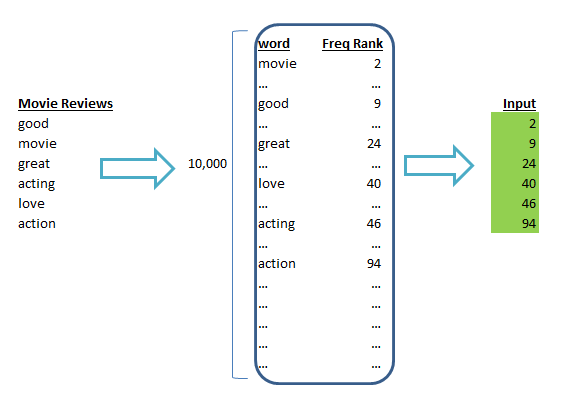

In [ ]:
# For simplicity, only consider the top frequent 10,000 words in the dataset (assume more frequent is more important)
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index
print('Found %s unique tokens but will only consider the top frequent %s words' %(len(word_index), max_words))

# convert the words to a seqence of numbers (index by the top frequency of the words)
# The words in the text sequence will be indexed as a number by the word_index
sequences = tokenizer.texts_to_sequences(train_text)

# show the word_index
df_wordIndex = pd.DataFrame.from_dict(word_index, orient='index', columns=['number'])[:max_words]
df_wordIndex

In [ ]:
index = 0
printInputOutput(index, train, train_text, train_label)

In [ ]:
# We will cut reviews after maxlen words because neural network input is fixed size vector
maxlen = 200 
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(train_label)

print('Shape of data tensor', data.shape)
print('Shape of labels tensor', labels.shape)

In [ ]:
# Now the training X, Y is the acceptable format by Neural Network
# Input X is a vectors and Y is the corresponding labels (i.e. the sentiment)
index = 0
print(data[index])
print("\n lable:", labels[index])

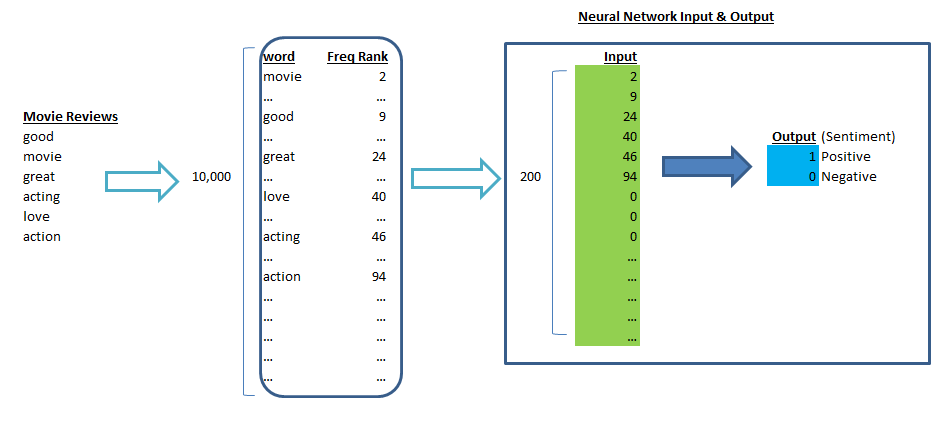

In [ ]:
training_samples = 16000  
validation_samples = 4000  
test_samples = 5000

# Split the data into a training set and a validation set
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

test_text = train_text[training_samples + validation_samples:]
test_label = train_label[training_samples + validation_samples:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Use the one hidden Dense layer connection which is similar to the MNIST (Digit) recognition
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(maxlen,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(model, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# The accuracy is not high. As human langauge is complex and the input contain 200 numbers, try with more neurons and layers?

*   As usual, the neural network will **learn the input/output associations** (i.e. map the sentence in sequence numberrs to the corresponding sentiment label)

*   However, in order to learning the associations (mapping) effectively, neural network needs to understand the text (which are now merely encoded as numbers by the frequency of appearance in the movies reviews) 

*   So the challenge is that the Neural Network has to learn 2 things (**input/output mapping and language understanding**) at the same time

*   Comparing to the image recognition, the pixel positions are naturally mapped to the vectors to represent the image spatial relationship.


In [ ]:
# The key idea here is to use word2vec (a pretrained vector which understand the text to certain extends) 
# to solve the 2nd issue (text understanding) and helps the neural network to learn the input/output mappings.
# Also, the word2vec output is a vector and which is exactly the required format for Neural Network

from gensim.models import word2vec

reviews = [sent.split(' ') for sent in train['preprocessed']]
w2vModel = word2vec.Word2Vec(reviews, min_count=5, size=64, window=5)
w2v = w2vModel.wv

print("No.of words in the vocab:", len(w2v.vocab))

In [ ]:
# w2v is a word represented by a vector of numbers
w2v['movie']

In [ ]:
w2v.most_similar('movie')

* Build the **embedding matrix** from the word2vec that we will be able to add to the Neural Network as a layer called **Embedding layer** each 
* For each row, it contains the corresponding word2vec vector to the word freqency index which built during earlier tokenization step.
* Think of the Embedding layer as another dictionary to map each number (the word indexed by the word frequency) to a vector (word2vec)


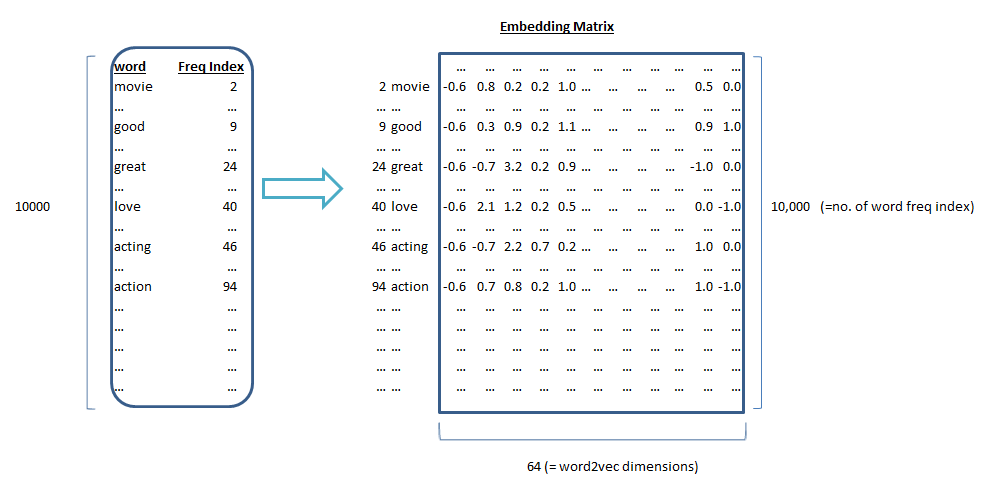

In [ ]:
# Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.
# The Embedding layer a matrix of shape (max_words, embedding_dim), 

embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  # Words not found in embedding index will be all-zeros.
  if word in w2v.vocab and i < max_words:
    embedding_matrix[i] = w2v[word]

print("embedding_matrix.shape:", embedding_matrix.shape)

In [ ]:
w2vModel = Sequential()

# Use w2v embedding layer to injects "pre-trained" language knowledge 
# to encode (represent) the input data more meaningfully
# It is a type of transfer learning 
w2vModel.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Then flatten the embedding output to a single vector for the hidden Dense layer 
# flatten the 200 sequence of 300-dim w2v vector into one single vector for dense layer
w2vModel.add(Flatten())
w2vModel.add(Dense(32, activation='relu'))
w2vModel.add(Dense(1, activation='sigmoid'))

plot_model(w2vModel, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...] --flatten--> [1,3,...4,7,5,...19,...] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

In [ ]:
w2vModel.summary()

# Embedding layer = max_words * embedding_dim = 10,000 * 300 = 3,000,000
# Flatten = (input) maxlen * embedding_dim = 200 * 300 = 60,000
# dense = flatten_output * dense_output_neurons + bias = 60,000 * 32 + 32 = 1,920,032
# dense_1 = dense_output * dense_1_output + bias = 32 * 1 + 1 = 33

In [ ]:
# Load the Embedding layer from the embedding_matrix and no need to train the parameters 

w2vModel.layers[0].set_weights([embedding_matrix])
w2vModel.layers[0].trainable = False
w2vModel.summary()

In [ ]:
# compile the model after setting the Embedding layer to non-trainable
w2vModel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = w2vModel.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## Try comparing to the dense connection with more neurons

In [ ]:
# Do the prediction on the test set
score = w2vModel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ans = w2vModel.predict(x_test)

In [ ]:
# Predict individual movie review
p_index = 0

print("Movie Review:", test_text[p_index])
print("Truth Sentiment:", test_label[p_index])
print("Predicted Sentiment:", round(ans[p_index][0]))

In [ ]:
# Change the neural network architecture from dense layer to LSTM which is better for sequence 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
from tensorflow.keras.layers import LSTM

lstm = Sequential()
lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# No need to flatten the vector (required for dense layer but not for LSTM)
lstm.add(LSTM(32))
lstm.add(Dense(1, activation='sigmoid'))

# Load the Embedding layer from the embedding_matrix and no need to train the parameters 
lstm.layers[0].set_weights([embedding_matrix])
lstm.layers[0].trainable = False

lstm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(lstm, show_shapes=True, show_layer_names=True)

# [good movie ....] --word_indexed_input--> [9,2,..,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...] 
#   --LSTM--> [[1,3,...,4], [7,5,...19],...] --dense_output--> 0 or 1

In [ ]:
lstm.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 300) + 32) = 42624

In [ ]:
history = lstm.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Suggested changes
# - Try with different max_words and maxlen in the data processing
# - Try with different training parameters for the word2vec (min_count, size, window)
# - When padding the text sequence to fixed size vector, removing some portion from the middle 
#       because usually the first and last sentence are more important as far as sentiment is concerned
# - Tune the neural network hyper-parameters
# - Train with other dataset such news sentiment dataset